## Implementation

To implement our code example, we'll begin by setting up the ROCm environment, akin to Nvidia Cuda but for AMD GPUs, along with the necessary packages and Python scripts. Notably, our code example is platform-agnostic, meaning it's compatible with AMD GPUs as well as other GPUs or TPUs, provided the GPU computing platform and Python packages are correctly configured.

### Environment Setup

Firstly, follow the environment setup instructions detailed in our [JAX NanoGPT implementation blog](https://rocm.blogs.amd.com/artificial-intelligence/nanoGPT-JAX/README.html#environment-setup). 

Next, install some extra packages needed for this tutorial.

```bash
pip install perfetto==0.7.0 matplotlib==3.8.4 scipy==1.13.0
```

Then, swap out the `model.py` and `sample.py` scripts in the `nanoGPT-JAX` folder with the corresponding files from the [`src` folder of this blog on GitHub](link_to_be_inserted). Specifically, observe the modifications made to the `model.py` file in the Side-by-Side comparison block below. We've appended two lines of code to assign unique names to annotate the two matrix multiplication steps using `jax.named_scope`, a context manager that incorporates a user-specified name into the JAX name stack. Consequently, we can subsequently extract profile data pertinent to these steps via the specified name. This technique proves invaluable for swiftly mapping logged operations of the same type in the profiling output to each step in an application or model as the default logged names may be confusing or very similar among operations of the same type. In the code block below, we have enclosed two different matrix multiplication steps and assigned them distinct scope names: `attn_q_k` and `attn_att_v`.

<table style="width: 100%;table-layout: fixed;">
<tr>
<th>Original `model.py`</th>
<th>Revised `model.py`</th>
</tr>
<tr style="vertical-align: top;">
<td style="width: 50%; overflow-x: auto;">

```python
class CausalSelfAttention(nn.Module):
    config: GPTConfig

    @nn.compact
    def __call__(self, x, train=False, rng1=None, rng2=None):
        assert self.config.n_embd % self.config.n_head == 0
        B, T, C = x.shape # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = jnp.split(nn.Dense(self.config.n_embd * 3, name="c_attn")(x), 3, axis=-1)
        k = k.reshape(B, T, self.config.n_head, C // self.config.n_head).swapaxes(1, 2) # (B, nh, T, hs)
        q = q.reshape(B, T, self.config.n_head, C // self.config.n_head).swapaxes(1, 2) # (B, nh, T, hs)
        v = v.reshape(B, T, self.config.n_head, C // self.config.n_head).swapaxes(1, 2) # (B, nh, T, hs)
        att = (jnp.einsum('bhts,bhqs->bhtq', q, k, optimize=True) if self.config.use_einsum else jnp.matmul(q, k.swapaxes(-2, -1))) * (1.0 / jnp.sqrt(k.shape[-1]))
        mask = jnp.tril(jnp.ones((T, T))).reshape((1, 1, T, T))
        att = jnp.where(mask == 0, float('-inf'), att)
        att = nn.softmax(att, axis=-1)
        att = nn.Dropout(self.config.dropout, name='attn_dropout', deterministic=not train)(att, rng=rng1)
        y = jnp.einsum('bhts,bhsq->bhtq', att, v, optimize=True) if self.config.use_einsum else jnp.matmul(att, v)   # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.swapaxes(1, 2).reshape(B, T, C)  # re-assemble all head outputs side by side
        # output projection
        y = nn.Dense(self.config.n_embd, name='c_proj')(y)
        y = nn.Dropout(self.config.dropout, name='resid_dropout', deterministic=not train)(y, rng=rng2)

        return y

```

</td>

<td style="width: 50%; overflow-x: auto;">

```python
class CausalSelfAttention(nn.Module):
    config: GPTConfig

    @nn.compact
    def __call__(self, x, train=False, rng1=None, rng2=None):
        assert self.config.n_embd % self.config.n_head == 0
        B, T, C = x.shape # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = jnp.split(nn.Dense(self.config.n_embd * 3, name="c_attn")(x), 3, axis=-1)
        k = k.reshape(B, T, self.config.n_head, C // self.config.n_head).swapaxes(1, 2) # (B, nh, T, hs)
        q = q.reshape(B, T, self.config.n_head, C // self.config.n_head).swapaxes(1, 2) # (B, nh, T, hs)
        v = v.reshape(B, T, self.config.n_head, C // self.config.n_head).swapaxes(1, 2) # (B, nh, T, hs)
        with jax.named_scope("attn_q_k"):
            att = (jnp.einsum('bhts,bhqs->bhtq', q, k, optimize=True) if self.config.use_einsum else jnp.matmul(q, k.swapaxes(-2, -1))) * (1.0 / jnp.sqrt(k.shape[-1]))
        mask = jnp.tril(jnp.ones((T, T))).reshape((1, 1, T, T))
        att = jnp.where(mask == 0, float('-inf'), att)
        att = nn.softmax(att, axis=-1)
        att = nn.Dropout(self.config.dropout, name='attn_dropout', deterministic=not train)(att, rng=rng1)
        with jax.named_scope("attn_att_v"):
            y = jnp.einsum('bhts,bhsq->bhtq', att, v, optimize=True) if self.config.use_einsum else jnp.matmul(att, v)   # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.swapaxes(1, 2).reshape(B, T, C)  # re-assemble all head outputs side by side
        # output projection
        y = nn.Dense(self.config.n_embd, name='c_proj')(y)
        y = nn.Dropout(self.config.dropout, name='resid_dropout', deterministic=not train)(y, rng=rng2)

        return y

```

</td>
</tr>
</table>

Here are the modifications applied to the original `sample.py` file. We wrapped the function responsible for executing inference on the JAX-based GPT model with `jax.profiler.start_trace` and `jax.profiler.stop_trace` to record the trace of each generated sample. It's worth noting that the profiling output for each sample will be stored in separate folders.

<table style="width: 100%;table-layout: fixed;">
<tr>
<th>Original `sample.py`</th>
<th>Revised `sample.py`</th>
</tr>
<tr style="vertical-align: top;">
<td style="width: 50%; overflow-x: auto;">

```python
for i in range(num_samples):
    output = generate([jnp.array(start_ids)], seed+i)
    print(f'\nGenerated output __{i}__: \n__________________________________\n{decode(output[0].tolist())}\n__________________________________')
```

</td>

<td style="width: 50%; overflow-x: auto;">

```python
def collect_trace():
    for i in range(num_samples): 
        jax.profiler.start_trace(profile_dir+f'_{i}')
        output = generate([jnp.array(start_ids)], seed+i)
        jax.profiler.stop_trace()
        print(f'\nGenerated output __{i}__: \n__________________________________\n{decode(output[0].tolist())}\n__________________________________')

collect_trace()

```

</td>
</tr>
</table>

### Profiling the GPT Model with Different Matrix Multiplication Algorithms in Self-Attention

The choice between using `einsum` or `matmul` for matrix multiplication is controlled by the `use_einsum` flag. We can collect profiling outputs for these two different algorithms by running the commands below:

```bash
# Generate profiling output using matmul
python sample.py --init_from='gpt2' --max_new_tokens=50 --start="The weather today is" --num_samples=10 --profile_dir="trace_file_matmul"

# Generate profiling output using einsum
python sample.py --init_from='gpt2' --max_new_tokens=50 --start="The weather today is" --num_samples=10 --profile_dir="trace_file_einsum" --override_args="{'use_einsum':True}"
```

This will generate 20 folders (10 folders for each algorithm, with 1 folder per generated sample) containing the profiling outputs. In each folder, the profiling output is stored in a compressed `.gz` file. Use the following command to unzip the output:

```bash
for i in {0..9}; do
    gzip -d trace_file_einsum_$i/plugins/profile/202*/*.json.gz
    gzip -d trace_file_matmul_$i/plugins/profile/202*/*.json.gz
done
```

### Statistical Analysis and Testing of Performance Between the Two Algorithms

Now, we are ready to read in the profiling data and perform statistical analysis. For each iteration (each corresponding to one generated sample for each algorithm), we will compare the distribution of the matrix multiplication execution times (in nanoseconds) between the two algorithms. We will use box plots to visually examine the differences and perform the [Wilcoxon rank-sum test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) to determine if the location parameters (e.g., mean and median) are significantly different.

In the code block below, we import the packages needed for the analysis and define the function to plot the box plots.

In [8]:
import glob
from perfetto.trace_processor import TraceProcessor
from scipy.stats import ranksums
import matplotlib.pyplot as plt


def plot_boxplot(df1, df2, columns1, columns2=None, df1_lab='matmul', df2_lab='einsum'):
    """
    Plot boxplots for specified columns in two DataFrames.

    Args:
    df1 (pandas.DataFrame): First DataFrame.
    df2 (pandas.DataFrame): Second DataFrame.
    columns1 (list): List of column names from the first DataFrame to plot.
    columns2 (list): List of column names from the second DataFrame to plot.
    df1_lab (string): Label for df1 in the plot.
    df2_lab (string): Label for df2 in the plot.
    """
    if columns2 is None:
        columns2 = columns1
    # Combine data from both DataFrames
    data = [df1[col] for col in columns1] + [df2[col] for col in columns2]
    
    # Create labels for boxplots
    labels = [df1_lab + '_' + col for col in columns1] + [df2_lab + '_' + col for col in columns2]
    
    # Plot boxplots
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.xlabel('Algorithms')
    plt.ylabel('Time in nanoseconds')
    plt.title('Performance comparison on the scale of nanoseconds')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


Then, we will compare the execution time between the two algorithms for each sample generation iteration. Please note that we use `where display_value like "%attn_q_k%"` in the SQL query to filter the operations enclosed in the first `named_scope`. You can modify the SQL query to explore different columns and compute metrics of your interest. 

We omitted the first iteration as it includes the compile time, which would skew the comparison. We will print the mean and standard deviation of execution times for each algorithm, as well as the dataframe shape, to ensure that your profiler and SQL query captured all events. For example, with 12 layers in the model and up to 50 new tokens per sample (resulting in up to 50 function calls to the model), there should be up to 12 times 50, equaling up to 600 matrix multiplication events captured.

Lastly, we will print the test statistic and p-value for the Wilcoxon rank-sum test, which assesses whether the location parameters (e.g., means and medians) of the execution time distributions for the two algorithms are significantly different.

###########i=1###########
##############################
Matmul: Mean=6461.875, std. dev.=504.8818364954699, shape of df:(600, 3)
Einsum: Mean=5813.346666666666, std. dev.=455.80420754410954, shape of df:(600, 3)


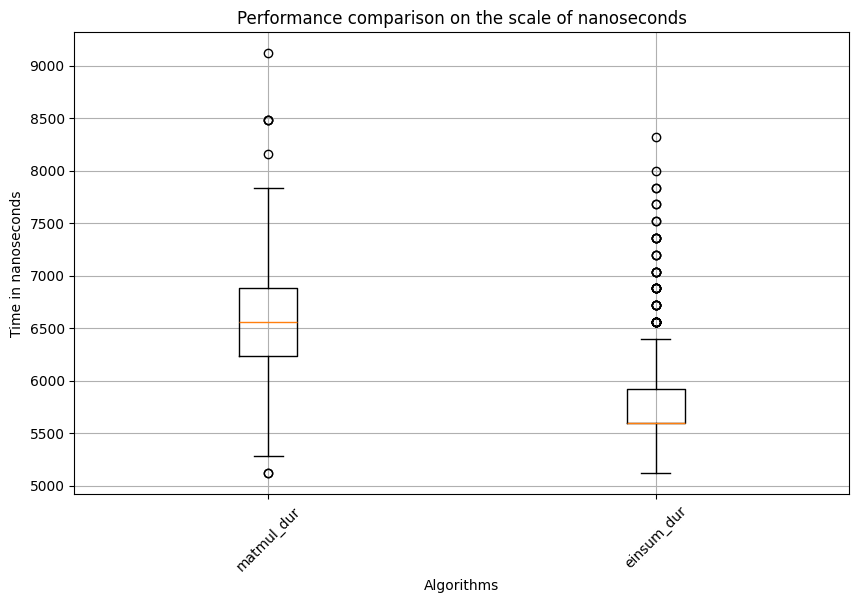

Test statistic=20.22982266255362, p_val=5.349499343834845e-91
###########i=2###########
##############################
Matmul: Mean=6293.076666666667, std. dev.=514.1309448993132, shape of df:(600, 3)
Einsum: Mean=5797.615, std. dev.=397.86885546863283, shape of df:(600, 3)


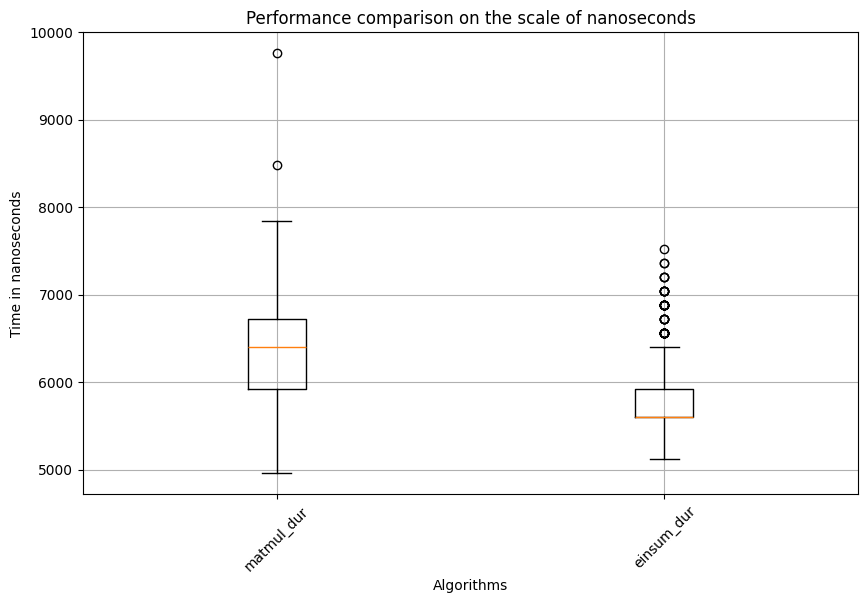

Test statistic=16.932946075063718, p_val=2.5717953759559878e-64
###########i=3###########
##############################
Matmul: Mean=6451.475, std. dev.=538.73375254872, shape of df:(600, 3)
Einsum: Mean=5757.885, std. dev.=388.0874879097756, shape of df:(600, 3)


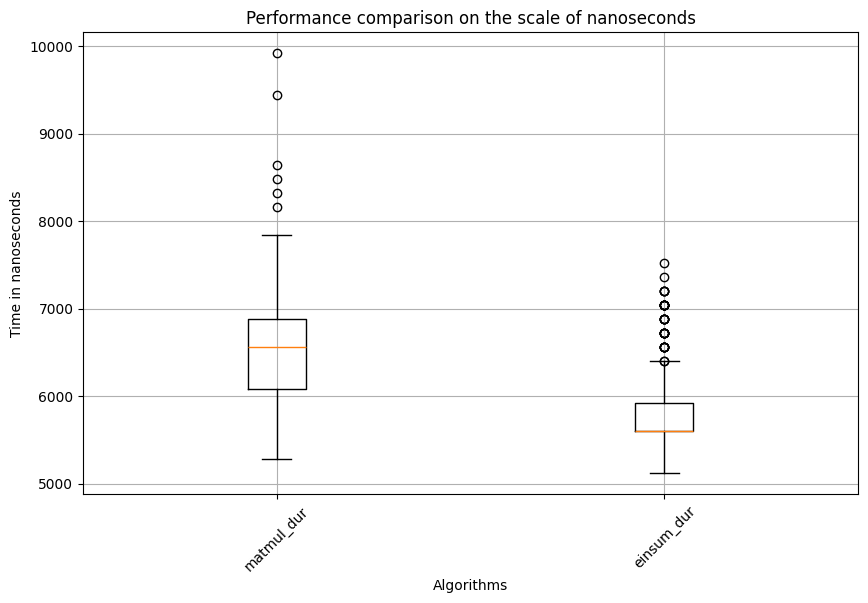

Test statistic=21.438152629913294, p_val=5.890599363920461e-102
###########i=4###########
##############################
Matmul: Mean=6205.345, std. dev.=533.82480663788, shape of df:(600, 3)
Einsum: Mean=6019.751666666667, std. dev.=7857.33635831784, shape of df:(600, 3)


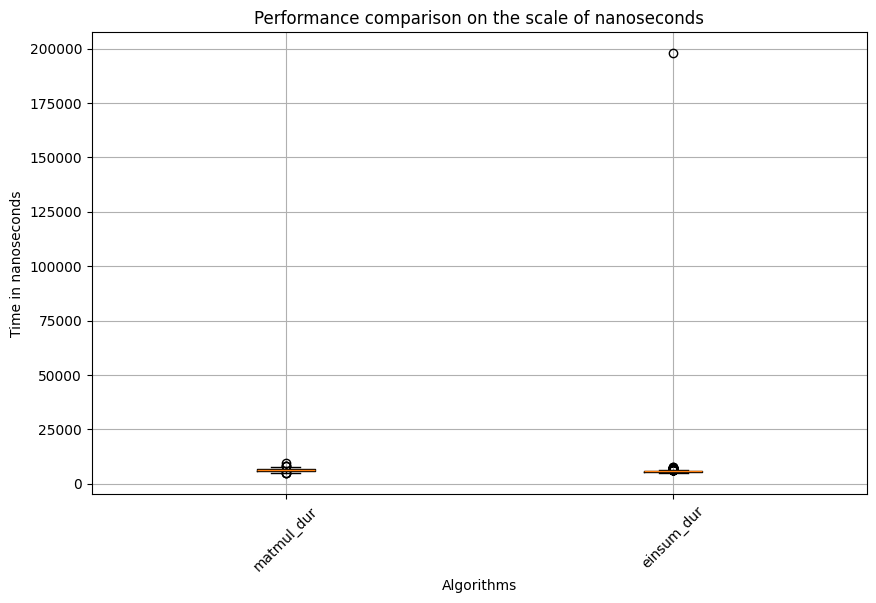

Test statistic=16.679801529992297, p_val=1.8382863056481595e-62
###########i=5###########
##############################
Matmul: Mean=6280.011666666666, std. dev.=526.8394548777791, shape of df:(600, 3)
Einsum: Mean=5697.345, std. dev.=411.5458410357097, shape of df:(600, 3)


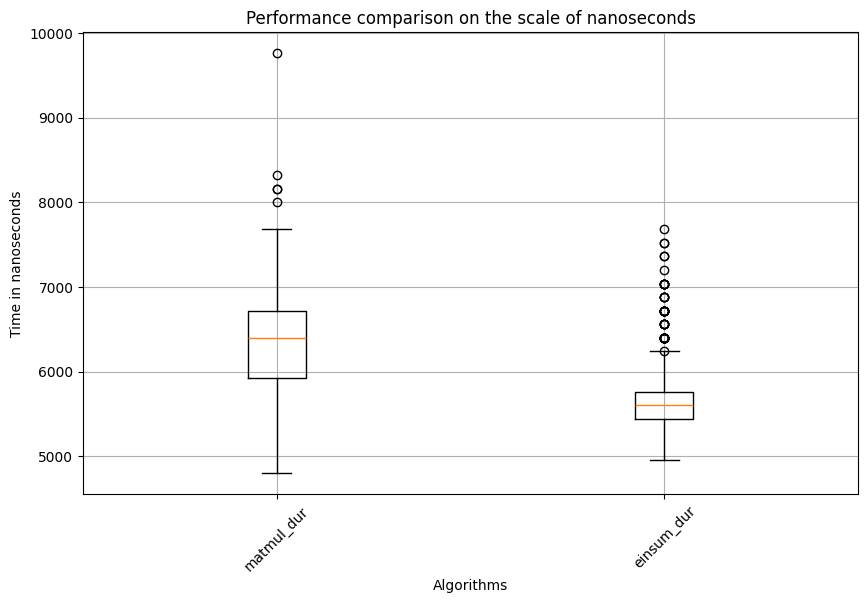

Test statistic=18.83656973038363, p_val=3.787296496629457e-79
###########i=6###########
##############################
Matmul: Mean=6295.213333333333, std. dev.=530.2012417470739, shape of df:(600, 3)
Einsum: Mean=5697.618333333333, std. dev.=398.23351091109413, shape of df:(600, 3)


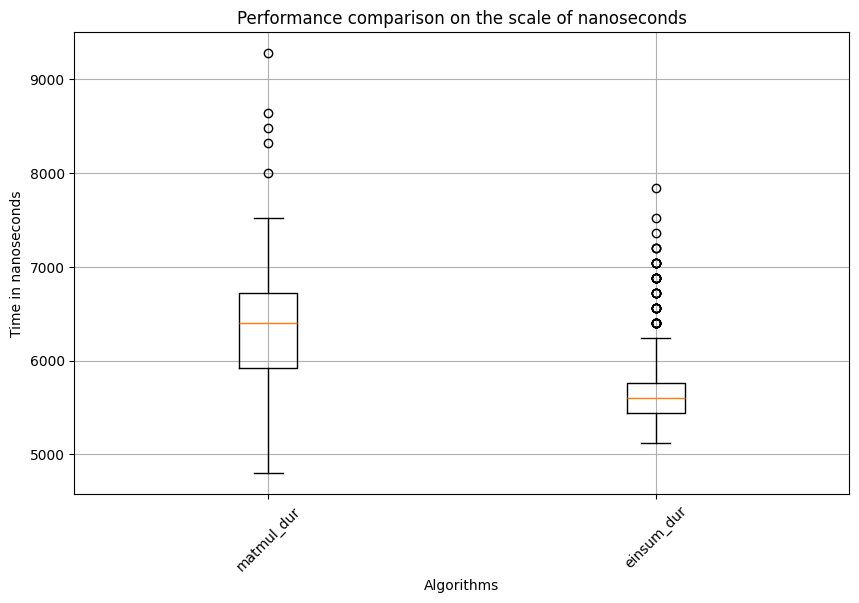

Test statistic=19.41482883926346, p_val=5.78283634284467e-84
###########i=7###########
##############################
Matmul: Mean=6269.346666666666, std. dev.=553.3298078747371, shape of df:(600, 3)
Einsum: Mean=5699.743333333333, std. dev.=422.30381438204523, shape of df:(600, 3)


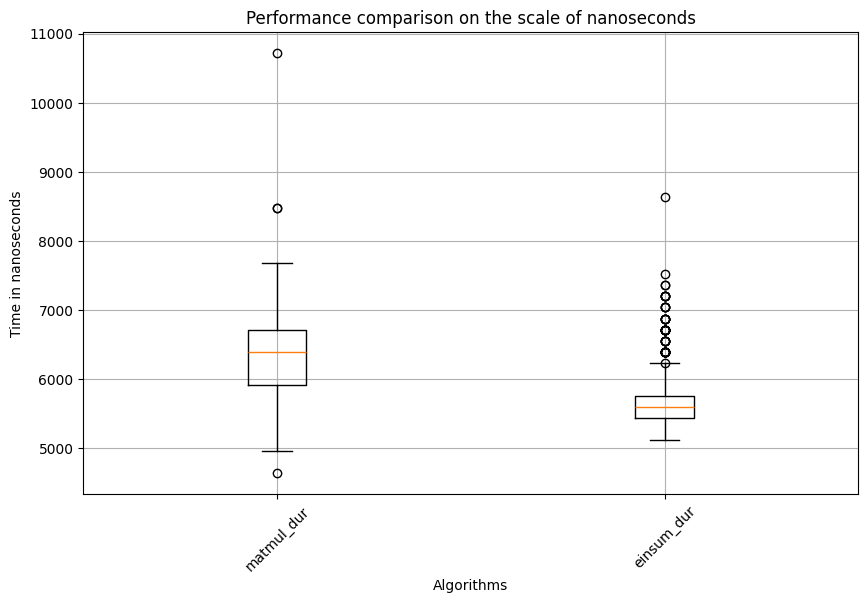

Test statistic=18.00308361061244, p_val=1.8426792456696994e-72
###########i=8###########
##############################
Matmul: Mean=6328.013333333333, std. dev.=545.5706603162282, shape of df:(600, 3)
Einsum: Mean=5638.143333333333, std. dev.=411.3339545419927, shape of df:(600, 3)


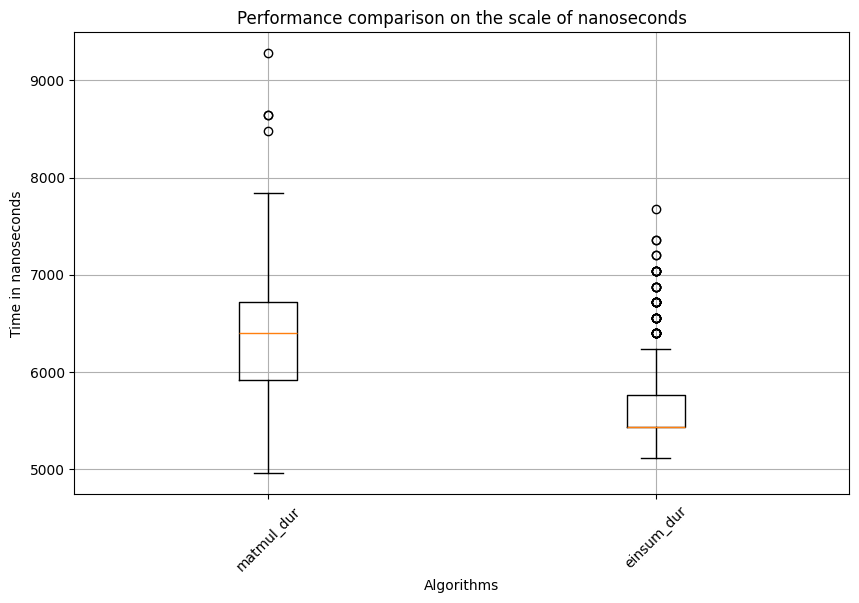

Test statistic=20.750105923006434, p_val=1.2232167096972136e-95
###########i=9###########
##############################
Matmul: Mean=6824.015, std. dev.=7569.880362944349, shape of df:(600, 3)
Einsum: Mean=5745.885, std. dev.=399.0683454609183, shape of df:(600, 3)


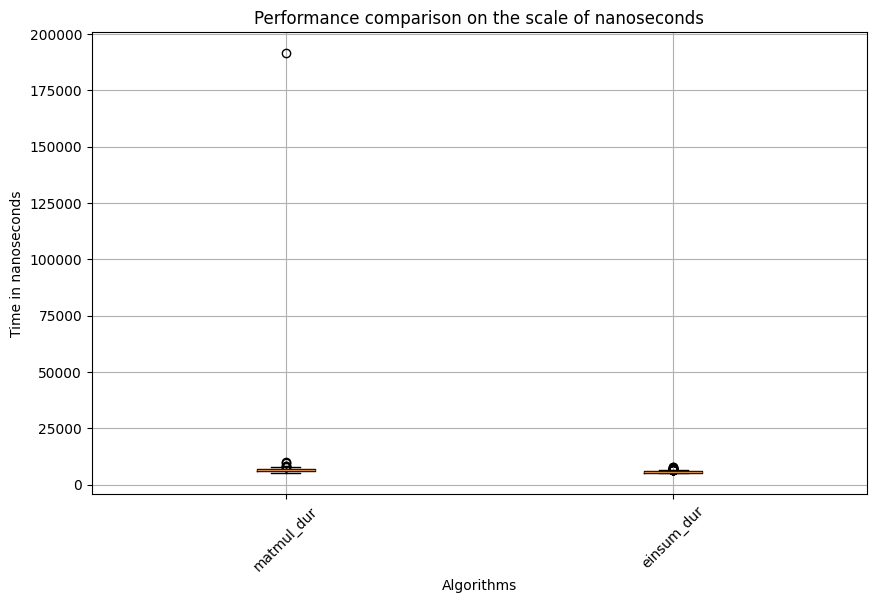

Test statistic=22.86597449469422, p_val=1.0136382089176869e-115


In [10]:
for i in range(1, 10):
    # Process the profiling data for matmul
    tp = TraceProcessor(trace=glob.glob(f'trace_file_matmul_{i}/plugins/profile/202*/*.json'))
    # SQL query to get the operations enclosed by the named_scope
    query_text='''INCLUDE PERFETTO MODULE slices.slices;
    WITH arg_sets_0 AS (
        SELECT DISTINCT arg_set_id, display_value
        FROM args
        WHERE key = 'args.name'
    )
    SELECT name, display_value,dur
        FROM _slice_with_thread_and_process_info
        INNER JOIN arg_sets_0 ON arg_sets_0.arg_set_id = _slice_with_thread_and_process_info.arg_set_id
    where display_value like "%attn_q_k%"
    '''
    # Query the profiling data and convert to dataframe
    qr_matmul = tp.query(query_text).as_pandas_dataframe()
    # Process the profiling data for einsum
    tp = TraceProcessor(trace=glob.glob(f'trace_file_einsum_{i}/plugins/profile/202*/*.json'))
    # Query the profiling data and convert to dataframe
    qr_einsum = tp.query(query_text).as_pandas_dataframe()
    print(f'###########i={i}###########')
    print('#'*30)
    # Print out the mean, standard dev. and shape for each algorithm
    print(f'Matmul: Mean={qr_matmul.dur.mean()}, std. dev.={qr_matmul.dur.std()}, shape of df:{qr_matmul.shape}')
    print(f'Einsum: Mean={qr_einsum.dur.mean()}, std. dev.={qr_einsum.dur.std()}, shape of df:{qr_einsum.shape}')
    plot_boxplot(qr_matmul, qr_einsum, ['dur'])
    stat, p = ranksums(qr_matmul['dur'], qr_einsum['dur'])
    print(f'Test statistic={stat}, p_val={p}')

Based on the results, it's evident that `matmul` takes significantly longer than `einsum` for calculating the matrix multiplication between the `query` and `key` matrices. But how does it perform for the matrix multiplication between the `attention` and `value` matrices? The results are shown in the code block below:

###########i=1###########
##############################
Matmul: Mean=5204.543333333333, std. dev.=882.6151202759834, shape of df:(600, 3)
Einsum: Mean=6360.556666666666, std. dev.=373.461514250933, shape of df:(600, 3)


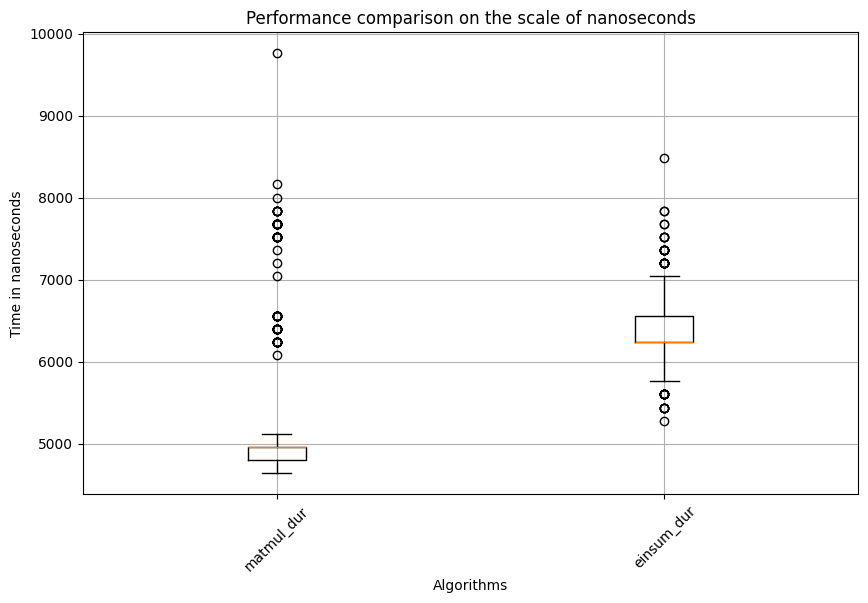

Test statistic=-21.986424230986046, p_val=3.884153635651101e-107
###########i=2###########
##############################
Matmul: Mean=5145.61, std. dev.=876.5247080600369, shape of df:(600, 3)
Einsum: Mean=6396.01, std. dev.=381.7892458942073, shape of df:(600, 3)


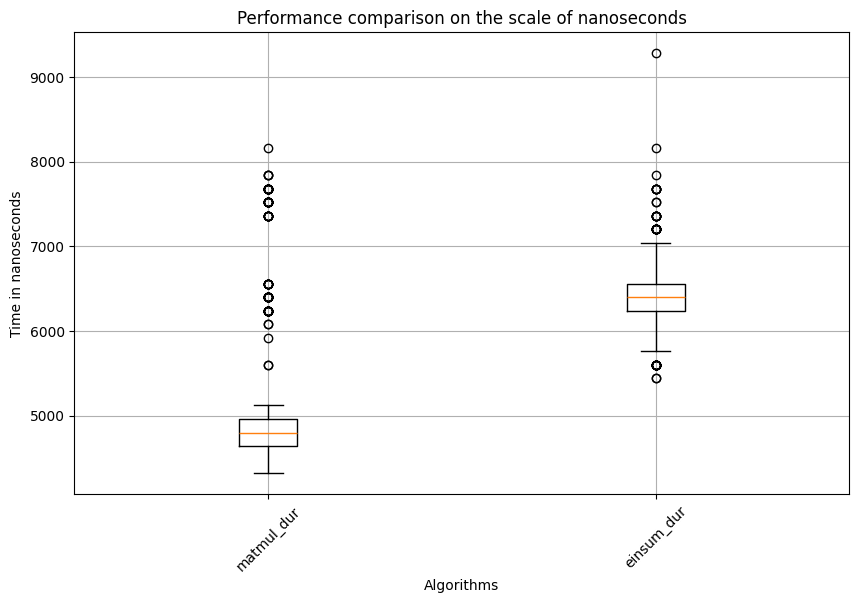

Test statistic=-22.450480914300588, p_val=1.2659476932444539e-111
###########i=3###########
##############################
Matmul: Mean=5224.553333333333, std. dev.=877.0896367382744, shape of df:(600, 3)
Einsum: Mean=6349.076666666667, std. dev.=357.3635945178245, shape of df:(600, 3)


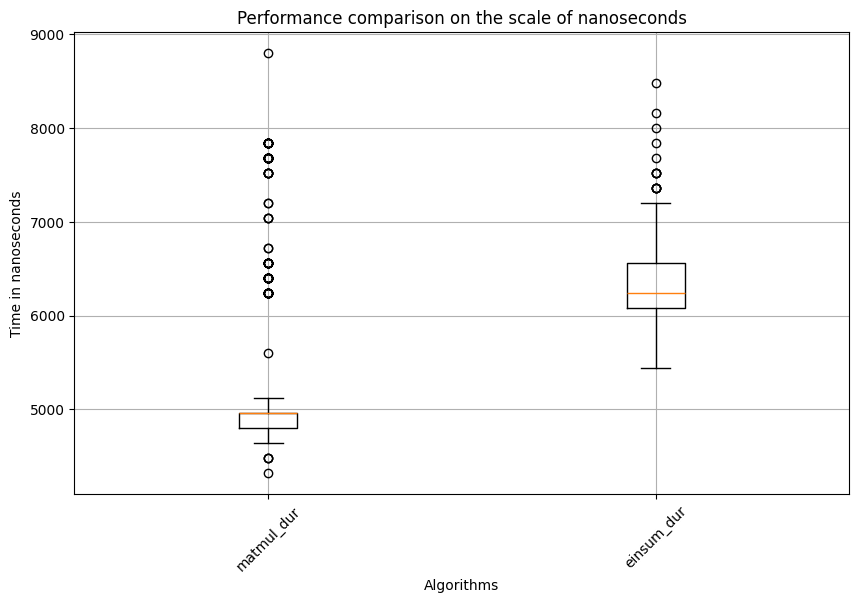

Test statistic=-21.769098098017523, p_val=4.555051355726863e-105
###########i=4###########
##############################
Matmul: Mean=5057.343333333333, std. dev.=872.136067933519, shape of df:(600, 3)
Einsum: Mean=6293.876666666667, std. dev.=374.859681868705, shape of df:(600, 3)


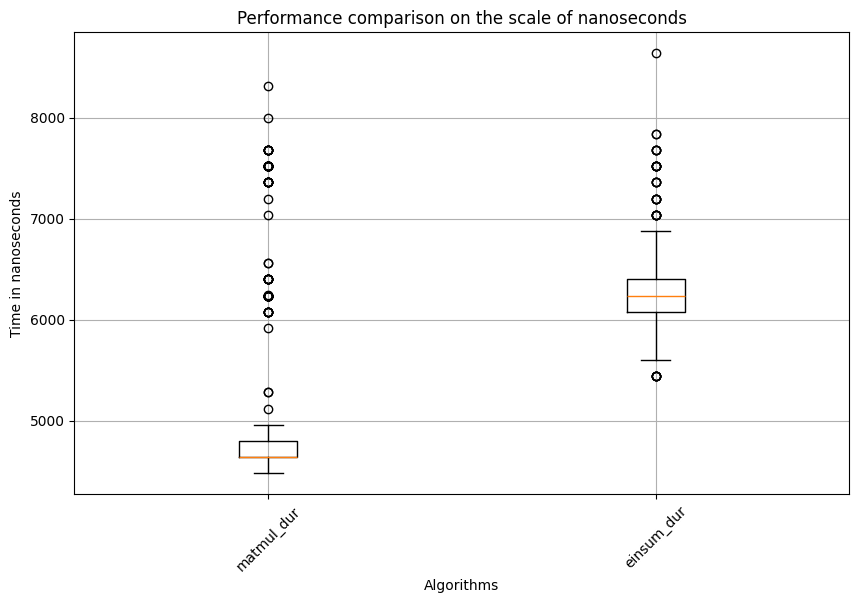

Test statistic=-22.56984785509932, p_val=8.574045249730023e-113
###########i=5###########
##############################
Matmul: Mean=5066.673333333333, std. dev.=874.2953699668464, shape of df:(600, 3)
Einsum: Mean=6274.945, std. dev.=384.56174823471747, shape of df:(600, 3)


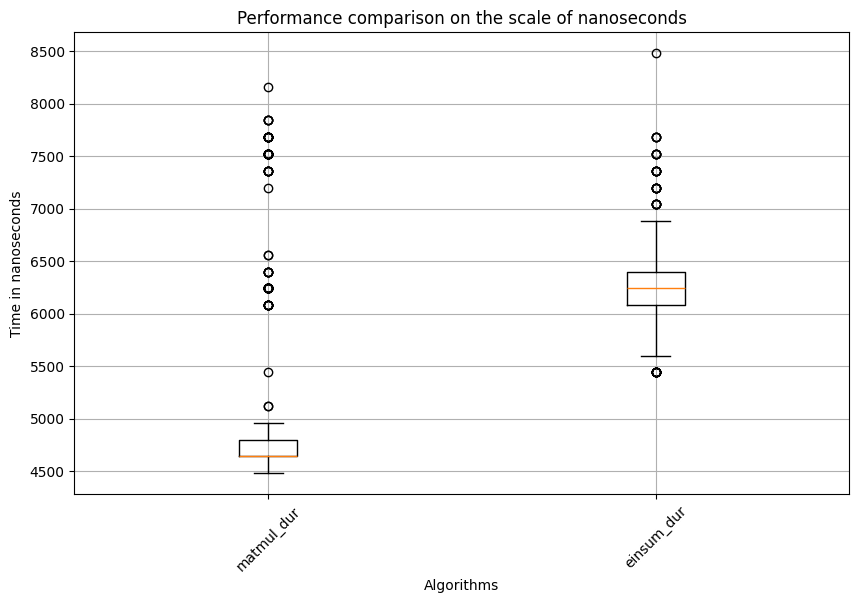

Test statistic=-22.569681257833725, p_val=8.606408150023678e-113
###########i=6###########
##############################
Matmul: Mean=5063.746666666667, std. dev.=884.868821091459, shape of df:(600, 3)
Einsum: Mean=6310.68, std. dev.=368.5406190817895, shape of df:(600, 3)


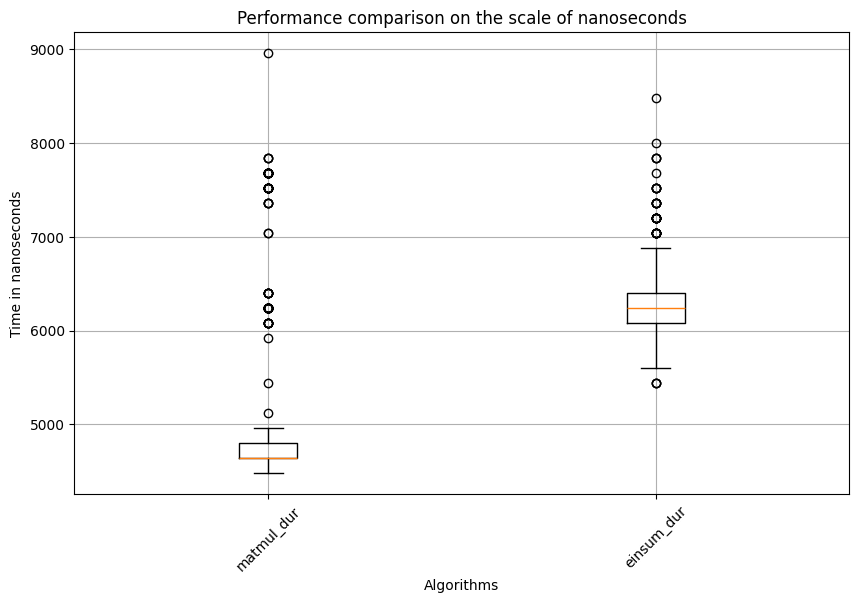

Test statistic=-22.873054878482005, p_val=8.618385507849066e-116
###########i=7###########
##############################
Matmul: Mean=5063.743333333333, std. dev.=876.820480132348, shape of df:(600, 3)
Einsum: Mean=6302.151666666667, std. dev.=403.65027507919285, shape of df:(600, 3)


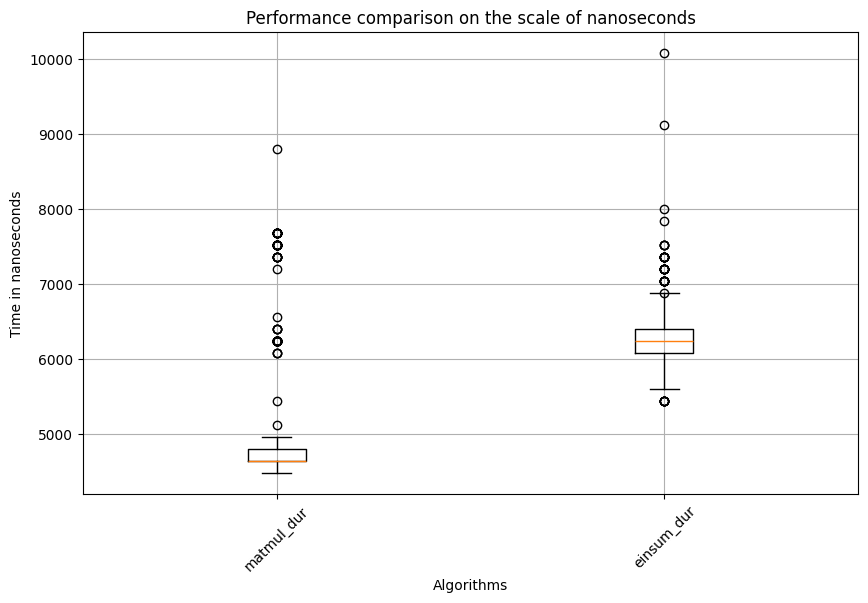

Test statistic=-22.543275591236938, p_val=1.5631560791126091e-112
###########i=8###########
##############################
Matmul: Mean=5074.683333333333, std. dev.=889.1356214386385, shape of df:(600, 3)
Einsum: Mean=6186.14, std. dev.=442.04220301770727, shape of df:(600, 3)


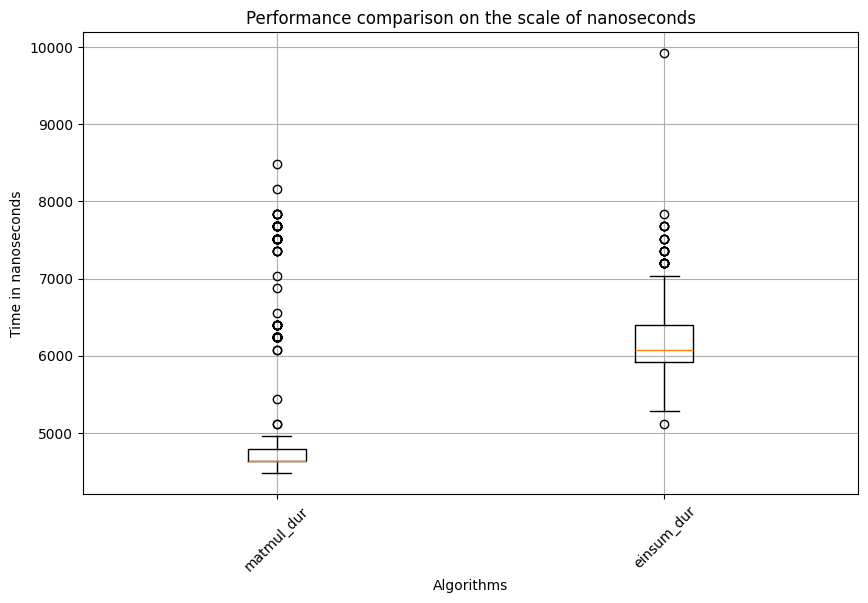

Test statistic=-21.74777364802138, p_val=7.251435434697252e-105
###########i=9###########
##############################
Matmul: Mean=5226.673333333333, std. dev.=896.6466222715281, shape of df:(600, 3)
Einsum: Mean=6293.61, std. dev.=408.9824229358161, shape of df:(600, 3)


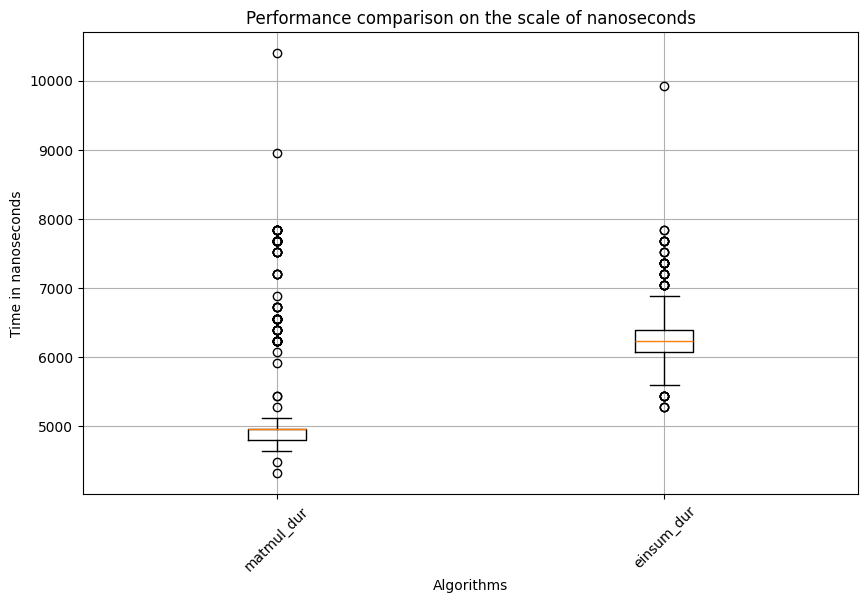

Test statistic=-21.559268842000773, p_val=4.333999941707689e-103


In [12]:
for i in range(1, 10):
    # Process the profiling data for matmul
    tp = TraceProcessor(trace=glob.glob(f'trace_file_matmul_{i}/plugins/profile/202*/*.json'))
    # SQL query to get the operations enclosed by the named_scope
    query_text='''INCLUDE PERFETTO MODULE slices.slices;
    WITH arg_sets_0 AS (
        SELECT DISTINCT arg_set_id, display_value
        FROM args
        WHERE key = 'args.name'
    )
    SELECT name, display_value,dur
        FROM _slice_with_thread_and_process_info
        INNER JOIN arg_sets_0 ON arg_sets_0.arg_set_id = _slice_with_thread_and_process_info.arg_set_id
    where display_value like "%attn_att_v%"
    '''
    # Query the profiling data and convert to dataframe
    qr_matmul = tp.query(query_text).as_pandas_dataframe()
    # Process the profiling data for einsum
    tp = TraceProcessor(trace=glob.glob(f'trace_file_einsum_{i}/plugins/profile/202*/*.json'))
    # Query the profiling data and convert to dataframe
    qr_einsum = tp.query(query_text).as_pandas_dataframe()
    print(f'###########i={i}###########')
    print('#'*30)
    # Print out the mean, standard dev. and shape for each algorithm
    print(f'Matmul: Mean={qr_matmul.dur.mean()}, std. dev.={qr_matmul.dur.std()}, shape of df:{qr_matmul.shape}')
    print(f'Einsum: Mean={qr_einsum.dur.mean()}, std. dev.={qr_einsum.dur.std()}, shape of df:{qr_einsum.shape}')
    plot_boxplot(qr_matmul, qr_einsum, ['dur'])
    stat, p = ranksums(qr_matmul['dur'], qr_einsum['dur'])
    print(f'Test statistic={stat}, p_val={p}')

This time, surprisingly, `matmul` is significantly faster than `einsum`. This indicates that one matrix multiplication algorithm may not always outperform the other; factors like matrix size, shape, and additional operations such as matrix transposition can all affect the speed. This highlights the importance of using profiling techniques to select the best algorithm for key steps of an application or model.

## Disclaimers

Third-party content is licensed to you directly by the third party that owns the content and is not licensed to you by AMD. ALL LINKED THIRD-PARTY CONTENT IS PROVIDED “AS IS” WITHOUT A WARRANTY OF ANY KIND. USE OF SUCH THIRD-PARTY CONTENT IS DONE AT YOUR SOLE DISCRETION AND UNDER NO CIRCUMSTANCES WILL AMD BE LIABLE TO YOU FOR ANY THIRD-PARTY CONTENT. YOU ASSUME ALL RISK AND ARE SOLELY RESPONSIBLE FOR ANY DAMAGES THAT MAY ARISE FROM YOUR USE OF THIRD-PARTY CONTENT.